 Importing data and libraries

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import LSTM, SpatialDropout1D, Activation, GlobalAveragePooling1D, Dense, Input, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [119]:
def load_data():
  data=pd.read_csv('https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv')
  data=data.drop('Unnamed: 0', axis=1)
  data=data.drop(labels=['hate_speech', 'offensive_language', 'neither', 'count'], axis=1)
  return data

In [120]:
label={0:'hate_speech', 1:'offensive_language', 2:'neither'}

In [121]:
def plot(data):
  sns.countplot(data['class'])
  plt.xlabel('Class')
  plt.title('Distribution of data in each class')
  plt.ylabel('Count')
  plt.show()

 Cleaning tweets

In [122]:
import re
def clean_text(data):
  for i in range(len(data)):
    txt = data.loc[i]["tweet"]
    txt=re.sub(r'@[A-Z0-9a-z_:]+','',txt) #replace username-tags
    txt=re.sub(r'^[RT]+','',txt) #replace RT-tags
    txt = re.sub('https?://[A-Za-z0-9./]+','',txt) #replace URLs
    txt=re.sub("[^a-zA-Z]", " ",txt) #replace hashtags
    data.at[i,"tweet"]=txt
  return data

In [123]:
def split_data(data):
  X=data['tweet']
  Y=data['class'].values
  Y=to_categorical(Y)
  X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.15)
  return X_train, y_train, X_test, y_test

 Applying tokenization on the training data

In [124]:
def create_token(X):
  token=Tokenizer()
  token.fit_on_texts(X)
  word_index = token.word_index
  
  sequences=token.texts_to_sequences(X)
  pad_sequence=sequence.pad_sequences(sequences)

  return token, pad_sequence, word_index

# Creating CNN model

In [125]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [126]:
%cd /content/gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [127]:
def index_vector():
  embeddings_index = {}
  f = open('glove.6B.100d.txt', encoding='utf-8')
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()
  return embeddings_index

def create_embed_matrix(word_index, embeddings_index):
  embedding_matrix = np.zeros((len(word_index) + 1, 100))
  for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
  return embedding_matrix

In [128]:
def cnn_model(nb_words, embedding_matrix, max_seq_len, num_classes=3):
  model = Sequential()
  embed_dim=100
  num_filters=64
  model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
  model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

  adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  model.summary()
  return model

# Creating LSTM model

In [129]:
def LSTM_model(max_words, max_phrase):
  model = Sequential()
  model.add(Embedding(input_dim = max_words, output_dim = 100, input_length = max_phrase))
  model.add(SpatialDropout1D(0.3))
  model.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(3, activation = 'softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
  model.summary()
  return model

In [130]:
def fit_model(model, pad_sequence):
  history = model.fit(pad_sequence, y_train, validation_split = 0.2, epochs = 10, batch_size = 128)
  return model, history

In [131]:
def plot_model(hist):
  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.title('Accuracy')
  plt.plot(np.arange(1, 11), hist.history['accuracy'], label='Training accuracy')
  plt.plot(np.arange(1, 11), hist.history['val_accuracy'], label='Val_accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Loss')
  plt.plot(np.arange(1, 11), hist.history['loss'], label='Training loss')
  plt.plot(np.arange(1, 11), hist.history['val_loss'],label='Val_loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

 Training and Testing the model

In [132]:
data = load_data()
data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


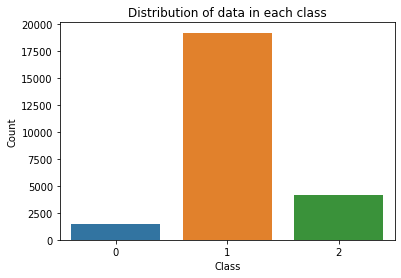

In [133]:
plot(data)

In [134]:
data = clean_text(data)
X_train, y_train, X_test, y_test = split_data(data)
print("Length of train data: {}".format(X_train.shape[0]))
print("Length of test data: {}".format(X_test.shape[0]))

Length of train data: 21065
Length of test data: 3718


In [135]:
token, train_pad, word_index = create_token(X_train)

# Train CNN_model

In [136]:
embeddings_index=index_vector()
embeddings_matrix=create_embed_matrix(word_index, embeddings_index)

100%|██████████| 18442/18442 [00:00<00:00, 534175.99it/s]


In [137]:
cnn_model = cnn_model(len(word_index)+1, embeddings_matrix, train_pad.shape[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 34, 100)           1844300   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 34, 64)            44864     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 17, 64)            28736     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)               

In [138]:
cnn_model, cnn_hist = fit_model(cnn_model, train_pad)

Epoch 1/10
132/132 [==============================] - 3s 26ms/step - loss: 0.3448 - accuracy: 0.7906 - val_loss: 0.2262 - val_accuracy: 0.8763
Epoch 2/10
132/132 [==============================] - 3s 25ms/step - loss: 0.2141 - accuracy: 0.8817 - val_loss: 0.1870 - val_accuracy: 0.9001
Epoch 3/10
132/132 [==============================] - 3s 25ms/step - loss: 0.1697 - accuracy: 0.9070 - val_loss: 0.1760 - val_accuracy: 0.9041
Epoch 4/10
132/132 [==============================] - 3s 25ms/step - loss: 0.1370 - accuracy: 0.9249 - val_loss: 0.1795 - val_accuracy: 0.9074
Epoch 5/10
132/132 [==============================] - 3s 25ms/step - loss: 0.1100 - accuracy: 0.9375 - val_loss: 0.1871 - val_accuracy: 0.9046
Epoch 6/10
132/132 [==============================] - 3s 25ms/step - loss: 0.0886 - accuracy: 0.9497 - val_loss: 0.2014 - val_accuracy: 0.9027
Epoch 7/10
132/132 [==============================] - 3s 25ms/step - loss: 0.0708 - accuracy: 0.9607 - val_loss: 0.2302 - val_accuracy: 0.8939

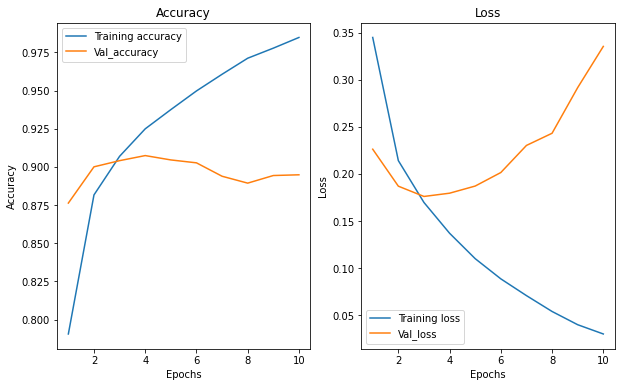

In [139]:
plot_model(cnn_hist)

# Train LSTM model

In [36]:
lstm_model = LSTM_model(len(word_index)+1, train_pad.shape[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 34, 100)           1851400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 34, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 771       
Total params: 2,283,531
Trainable params: 2,283,531
Non-trainable params: 0
____________________________________________

In [37]:
lstm_model, lstm_hist = fit_model(lstm_model, train_pad)

Epoch 1/10
132/132 [==============================] - 32s 239ms/step - loss: 0.5540 - accuracy: 0.8103 - val_loss: 0.3706 - val_accuracy: 0.8785
Epoch 2/10
132/132 [==============================] - 31s 235ms/step - loss: 0.2997 - accuracy: 0.9018 - val_loss: 0.3213 - val_accuracy: 0.8868
Epoch 3/10
132/132 [==============================] - 31s 232ms/step - loss: 0.2146 - accuracy: 0.9275 - val_loss: 0.3276 - val_accuracy: 0.8846
Epoch 4/10
132/132 [==============================] - 30s 229ms/step - loss: 0.1613 - accuracy: 0.9426 - val_loss: 0.3520 - val_accuracy: 0.8908
Epoch 5/10
132/132 [==============================] - 31s 231ms/step - loss: 0.1245 - accuracy: 0.9567 - val_loss: 0.3605 - val_accuracy: 0.8899
Epoch 6/10
132/132 [==============================] - 30s 230ms/step - loss: 0.1015 - accuracy: 0.9638 - val_loss: 0.4227 - val_accuracy: 0.8827
Epoch 7/10
132/132 [==============================] - 31s 231ms/step - loss: 0.0805 - accuracy: 0.9718 - val_loss: 0.4509 - val_ac

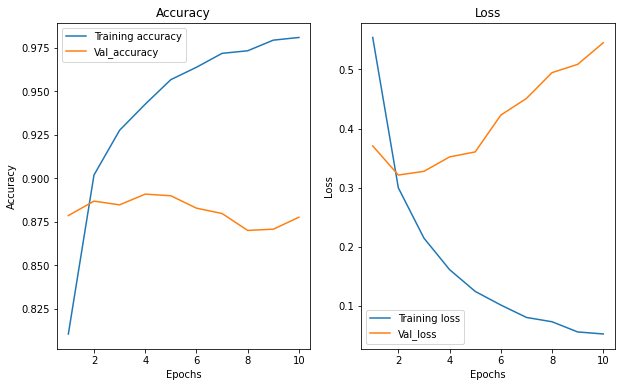

In [38]:
plot_model(lstm_hist)

In [142]:
def check_accuracy(model, X_test, y_test):
  test_sequences=token.texts_to_sequences(X_test)
  test_pad=sequence.pad_sequences(test_sequences, maxlen=train_pad.shape[1])
  y_pred = model.predict(test_pad)
  acc=model.evaluate(test_pad, y_test)
  print("Accuracy: {}".format(acc[1]))
  y_test_=np.argmax(y_test, axis=1)
  y_pred=np.argmax(y_pred, axis=1)
  print(metrics.classification_report(y_test_, y_pred))
  cm = confusion_matrix(y_test_, y_pred, normalize='true')
  
  np.set_printoptions(precision=2)
  # cm = confusion_matrix(y_test, y_pred)

  cm_display = ConfusionMatrixDisplay(cm, display_labels=label.values()).plot(cmap=plt.cm.Blues)

# Train Logistic regression

In [40]:
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=10000)

In [41]:
X_train_text = text_transformer.fit_transform(X_train)
X_test_text = text_transformer.transform(X_test)

In [42]:
logit = LogisticRegression(C=5, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [43]:
y_train_org = np.argmax(y_train, axis=1)
y_test_org = np.argmax(y_test, axis=1)

In [44]:
cv_results = cross_val_score(logit, X_train_text, y_train_org, cv=skf, scoring='f1_micro')
logit.fit(X_train_text, y_train_org)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=4, penalty='l2',
                   random_state=17, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Compare accuracy

CNN accuracy : 
117/117 [==============================] - 0s 3ms/step - loss: 0.3290 - accuracy: 0.8943
Accuracy: 0.8942980170249939
              precision    recall  f1-score   support

           0       0.46      0.25      0.32       222
           1       0.92      0.96      0.94      2903
           2       0.84      0.83      0.84       593

    accuracy                           0.89      3718
   macro avg       0.74      0.68      0.70      3718
weighted avg       0.88      0.89      0.89      3718



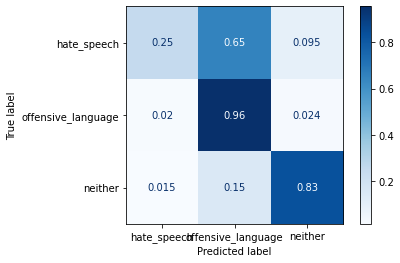

In [143]:
from sklearn import metrics
print("CNN accuracy : ")
check_accuracy(cnn_model, X_test, y_test)

LSTM accuracy : 
117/117 [==============================] - 2s 20ms/step - loss: 0.1993 - accuracy: 0.9505
Accuracy: 0.9505110383033752
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       219
           1       0.96      0.98      0.97      2852
           2       0.96      0.91      0.93       647

    accuracy                           0.95      3718
   macro avg       0.90      0.86      0.88      3718
weighted avg       0.95      0.95      0.95      3718

[[0.68 0.3  0.02]
 [0.01 0.98 0.01]
 [0.01 0.08 0.91]]


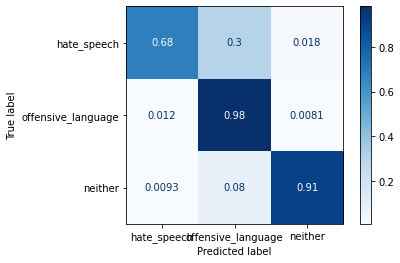

In [109]:
print("LSTM accuracy : ")
check_accuracy(lstm_model, X_test, y_test)

Logistic regression accuracy : 
              precision    recall  f1-score   support

           0       0.07      0.03      0.04       219
           1       0.77      0.81      0.79      2852
           2       0.19      0.18      0.19       647

    accuracy                           0.65      3718
   macro avg       0.34      0.34      0.34      3718
weighted avg       0.63      0.65      0.64      3718



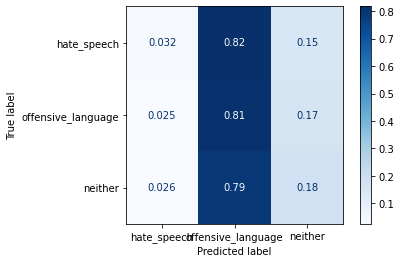

In [117]:
print("Logistic regression accuracy : ")
logit.score(X_test_text, y_test_org)
y_pred = logit.predict(X_test_text)
y_test_=np.argmax(y_test, axis=1)
print(metrics.classification_report(y_test_, y_pred))
cm = confusion_matrix(y_test_, y_pred, normalize='true')

np.set_printoptions(precision=2)
# cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm, display_labels=label.values()).plot(cmap=plt.cm.Blues)